In [1]:
import sys

# To make the modules visible

sys.path.append("../")

In [2]:
from models.battery_models import prepare_linear_battery_model

from models.data_handling import BatteryData, NESTData
from models.recurrent import LSTMModel

from parameters import data_kwargs, model_kwargs, ROOMS


Usage of the TensorBoard is on!



/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [3]:
data_kwargs["start_date"] = '2020-04-03'
data_kwargs["end_date"] = '2020-04-11'

battery_data = BatteryData(data_kwargs)
nest_data = NESTData(data_kwargs)

Trying to load the Battery data...
Data downloaded sucessfully!
Preparing the data...
Trying to load the Weather data...
Data downloaded sucessfully!
Trying to load the Battery data...
Data downloaded sucessfully!
Trying to load the Rooms data...
Data downloaded sucessfully!
Trying to load the DHW_HP data...
Data downloaded sucessfully!
Trying to load the Electricity data...
Data downloaded sucessfully!
Trying to load the Valves data...
Data downloaded sucessfully!
Trying to load the Thermal data...
Data downloaded sucessfully!
Adding the time information

Dropped 0 datapoints were all values were missing
Interpolated 0 datapoints.

DataSet created successfully!
Dropped 5 inconsistent points
Warning, columns [ 5 29 30] are constant, really useful?

Data ready!


../models/data_handling.py:125: RuntimeWarning: invalid value encountered in greater
  inconsistencies = np.where(((np.abs(dataset.data["Thermal total energy"].values) > 0.025) & (valves == 0)) |
../models/data_handling.py:126: RuntimeWarning: invalid value encountered in less
  ((np.abs(dataset.data["Thermal total energy"].values) < 0.025) & (valves > 0)))[0]
../models/data_handling.py:152: RuntimeWarning: invalid value encountered in less
  temperatures[(difference < -0.5) | (difference > 0.5)] = np.nan
../models/data_handling.py:152: RuntimeWarning: invalid value encountered in greater
  temperatures[(difference < -0.5) | (difference > 0.5)] = np.nan


In [4]:
battery_model = prepare_linear_battery_model(data_kwargs, show_model=False, show_predictions=False)
umar_model = LSTMModel(nest_data=nest_data,
                  model_kwargs=model_kwargs)

Trying to load the Battery data...
Data downloaded sucessfully!
Model loaded successfully.

Constructing the LSTM model...
Indeed, the output is currently passed through a sigmoid which crushes it between 0 and 1
Trying to load the predictable indices, where the data has no missing values...
Found!

Trying to load a trained model...
Found!
The model has been fitted for 30 epochs already, with loss  0.06621.


In [5]:
umar_model.dataset.max_["Thermal total energy"]

1.825188425012995

In [6]:
umar_model.data.columns

Index(['HP electricity consumption', 'Thermal valve 272', 'Thermal valve 273',
       'Thermal valve 274', 'Thermal valve 275', 'Thermal valve 276',
       'Weather relative humidity', 'Weather solar irradiation',
       'Weather wind speed', 'Weather wind direction',
       'Weather relative air pressure', 'Weather outside temperature',
       'Room 272 window', 'Room 272 humidity', 'Room 272 brightness',
       'Room 273 humidity', 'Room 273 brightness', 'Room 274 window',
       'Room 274 humidity', 'Room 274 brightness', 'Room 273 windows',
       'HP Boiler temperature', 'Electricity total consumption',
       'Thermal inlet temperature', 'Thermal temperature measurement 272',
       'Thermal temperature measurement 273',
       'Thermal temperature measurement 274',
       'Thermal temperature measurement 275',
       'Thermal temperature measurement 276', 'Time month sin',
       'Time month cos', 'Time weekday', 'Time interval sin',
       'Time interval cos', 'Thermal total en

In [8]:
del umar_model.losses
del umar_model.optimizer
del umar_model.writer

In [11]:
import pandas as pd
temp =  pd.DataFrame(index=umar_model.data.index)
battery_model.data = temp.join(battery_model.data)
battery_model.data.iloc[:,0].interpolate(inplace=True)

In [12]:
temp_bounds = [21, 23]

In [ ]:
import gym
from gym import spaces

from stable_baselines.common.env_checker import check_env

import numpy as np
import random
import torch
import matplotlib.pyplot as plt

class UMAREnvNOTLSTM(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, umar_model, battery_model, temp_bounds, save_path="../saves/Agents/"):
        super(UMAREnv, self).__init__()

        self.umar_model = umar_model
        self.umar_model.model.eval()
        self.battery_model = battery_model
        
        self.current_sequence = None
        self.current_data = None
        self.current_step = 0
        self.h = None
        self.c = None
        
        self.current_battery = None
        
        self.observation_columns, self.control_columns, self.predictions_columns = self.get_columns()
        
        self.temp_bounds = temp_bounds
        self.zero_energy, self.scaled_temp_bounds = self.compute_scaled_limits(temp_bounds)

        self.observation_space = spaces.Box(low=np.array([0.09]*len(self.observation_columns)+[0.]),
                                            high=np.array([0.91]*len(self.observation_columns)+[100.]), dtype=np.float64)

        self.action_space = spaces.Box(low=np.array([-1.]*(len(ROOMS)+1)),
                                       high=np.array([1.]*(len(ROOMS)+1)), dtype=np.float64)
        
        self.device, self.save_path = self.training_setup(save_path)
        

    def reset(self):
                
        self.current_sequence = random.choice(self.umar_model.sequences)
        self.current_data = self.umar_model.data.iloc[self.current_sequence, :].copy().values
        self.current_data[1:, self.predictions_columns] = np.nan
        self.current_data[:, self.control_columns] = np.nan
        self.current_step = 0
        
        observation = self.current_data[0, self.observation_columns]
        
        self.battery_soc = []
        self.battery_powers = []
        self.battery_soc.append(self.battery_model.data.loc[self.umar_model.data.index[self.current_sequence[0]]][0])
        
        observation = np.append(observation, self.battery_soc[0])
        
        self.h, self.c = self.umar_model.warm_start(sequence=self.current_sequence)
                  
        return observation  # reward, done, info can't be included
    
    def step(self, action):
                        
        reward = -np.sum(np.abs(action))
        
        action[:-1] = 0.8*np.abs(action[:-1]) + 0.1
        action[-1] = 10.*action[-1]
        
        self.current_data[self.current_step, self.control_columns] = action[:-1]
        
        input_tensor = torch.FloatTensor(self.current_data[self.current_step]).view(1,1,-1).to(self.device)
        
        output, (self.h, self.c) = self.umar_model.model(input_tensor,
                                               h_0=self.h,
                                               c_0=self.c)
        
        prediction = np.array([output[x].squeeze().detach().numpy()
                      for x in self.umar_model.data.columns
                      if x in self.umar_model.components])
        prediction = prediction.clip(0.1,0.9)
        
        if np.sum(action[:-1]) == len(ROOMS)*0.1+1e-6:
            print("No energy")
            prediction[-1] = self.zero_energy
        
        self.current_step += 1
        self.current_data[self.current_step, self.predictions_columns] = prediction
        
        observation = self.current_data[self.current_step, self.observation_columns]
        
        self.battery_powers.append(action[-1])
        self.battery_soc.append((self.battery_soc[-1] + self.battery_model.predict(action[-1])).clip(0,100))
        
        observation = np.append(observation, self.battery_soc[-1])   
        reward = self.compute_reward(observation, action)
        
        done = True if self.current_step == len(self.current_sequence) - 1 else False
        
        info = {}
        
        return observation, reward, done, info
    
    def compute_reward(self, observation, action):
        
        temperatures = self.current_data[self.current_step, self.predictions_columns[:-1]]
        lower_violations = (self.scaled_temp_bounds[0,:] - temperatures)
        lower_violations = np.sum(lower_violations[lower_violations>0])
        higher_violations = (temperatures - self.scaled_temp_bounds[1,:])
        higher_violations = np.sum(higher_violations[higher_violations>0])
        
        comfort_violations = 4 *(lower_violations + higher_violations)
        return - comfort_violations
        #return -np.sum(action[:-1]) - np.abs(observation[-2] - self.zero_energy) - (1/25)*np.abs(action[-1]) - comfort_violations
    
    def get_columns(self):
        observation_columns = [i for i in range(len(self.umar_model.data.columns))
                                     if "valve" not in self.umar_model.data.columns[i]]
        control_columns = [i for i in range(len(self.umar_model.data.columns))
                                     if "valve" in self.umar_model.data.columns[i]]
        predictions_columns = [i for i in range(len(self.umar_model.data.columns))
                                     if self.umar_model.data.columns[i] in self.umar_model.components]
        
        return observation_columns, control_columns, predictions_columns
    
    def compute_scaled_limits(self, temp_bounds):
        zero_energy = (-self.umar_model.dataset.min_["Thermal total energy"])/\
            (self.umar_model.dataset.max_["Thermal total energy"] - umar_model.dataset.min_["Thermal total energy"])\
            *0.8 + .1
        
        scaled_temp_bounds = np.zeros((2, len(ROOMS)))
        j = 0
        for i, room in enumerate(self.umar_model.data.columns):
            if i in self.predictions_columns[:-1]:
                scaled_temp_bounds[:,j] = (temp_bounds-self.umar_model.dataset.min_[room])/\
                    (self.umar_model.dataset.max_[room] - umar_model.dataset.min_[room])*0.8 + .1
                j += 1
        
        return zero_energy, scaled_temp_bounds
    
    def training_setup(self, save_path):
        # Define the device (for colab)
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("GPU acceleration on!")

            # We also need to overwrite the save path to make it work with colab
            save_path = "/content/drive/My Drive/DRL/saves/Models"
        else:
            device = "cpu"
            save_path = save_path
            
        return device, save_path
            
    def render(self, mode='human'):
        if self.current_step == len(self.current_sequence)-1:
            index = self.umar_model.data.index[self.current_sequence]
            data = self.umar_model.dataset.inverse_normalize(pd.DataFrame(data=self.current_data,
                                                                         columns=self.umar_model.data.columns,
                                                                         index=index))
            print(data.head())
            
            if np.sum(
                    np.mean(data.loc[:, [f"Thermal temperature measurement {room}" for room in ROOMS]].values,
                            axis=1) > data.loc[:, "Thermal inlet temperature"]) > 95:
                case = "Cooling"
            elif np.sum(
                    np.mean(data.loc[:, [f"Thermal temperature measurement {room}" for room in ROOMS]].values,
                            axis=1) < data.loc[:, "Thermal inlet temperature"]) > 95:
                case = "Heating"
            else:
                case = "Other"
            
            print(f"\n==================================\n{case} case\n==================================")
            
            fig, axes = plt.subplots(7,2,figsize=(16,25), sharex = True)
            fig.autofmt_xdate()
            for num, (i, j) in enumerate(zip(self.predictions_columns, self.control_columns)):
                axis = axes[num - (num%2),num%2]
                axis.plot(data.iloc[:,i], label="Temperature")
                axis.plot(index, [self.temp_bounds[0]]*97, color="red", label="Bounds")
                axis.plot(index, [self.temp_bounds[1]]*97, color="red")
                ylim = axis.get_ylim()
                axis.legend(prop={'size': 15})
                axis.set_title(f"Room temperature {self.umar_model.data.columns[i][-3:]}", size=22)
                axis.set_ylabel("Degrees ($^\circ$C)", size=20)
                axis = axes[num - (num%2)+1,num%2]
                axis.plot(data.iloc[:,j]*100, color="orange")
                axis.set_title(f"Valves {self.umar_model.data.columns[i][-3:]}", size=22)
                axis.set_ylabel("Opening (%)", size=20)
            axes[4,1].plot(index, data.iloc[:, self.predictions_columns[-1]])
            axes[4,1].set_title("Energy consumption", size=22)
            axes[4,1].set_ylabel("Energy (kWh/15 min)", size=20)
            axes[5,1].plot(index, np.nansum(data.iloc[:, self.control_columns].values, axis=1)*100, color="orange")
            axes[5,1].set_title("Sum of the valves opening", size=22)
            axes[5,1].set_ylabel("Total valve openings", size=20)
            axes[6,0].plot(index, self.battery_soc)
            axes[6,0].set_title("Battery SoC", size=22)
            axes[6,0].set_ylabel("SoC (%)", size=20)
            axes[6,1].plot(index[1:], self.battery_powers)
            axes[6,1].set_title("Battery Power Input", size=22)
            axes[6,1].set_ylabel("Power (kW)", size=20)
            for i in range(2):
                for j in range(7):
                    axes[j,i].tick_params(axis='y', which='major', labelsize=15)
                if j == 6:
                    axes[j,i].tick_params(axis='x', which='major', labelsize=15)
                    axes[j,i].set_xlabel("Time", size=20)
            plt.tight_layout()
            plt.show()
   
    def close (self):
        pass
    

env = UMAREnv(umar_model, battery_model, temp_bounds)
# It will check your custom environment and output additional warnings if needed
check_env(env)

In [64]:
import gym
from gym import spaces

from stable_baselines.common.env_checker import check_env

import numpy as np
import random
import torch
import matplotlib.pyplot as plt

class UMAREnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, umar_model, battery_model, temp_bounds, save_path="../saves/Agents/"):
        super(UMAREnv, self).__init__()

        self.umar_model = umar_model
        self.umar_model.model.eval()
        self.battery_model = battery_model
        
        self.current_sequence = None
        self.current_data = None
        self.current_step = 0
        self.h = None
        self.c = None
        
        self.current_battery = None
        
        self.observation_columns, self.control_columns, self.predictions_columns = self.get_columns()
        
        self.temp_bounds = temp_bounds
        self.zero_energy, self.scaled_temp_bounds = self.compute_scaled_limits(temp_bounds)

        self.observation_space = spaces.Box(low=np.array([0.09]*len(self.observation_columns)+[0.]),
                                            high=np.array([0.91]*len(self.observation_columns)+[100.]), dtype=np.float64)

        self.action_space = spaces.MultiDiscrete([11,11,11,11,11,11])
        
        self.device, self.save_path = self.training_setup(save_path)
        

    def reset(self):
                
        self.current_sequence = random.choice(self.umar_model.sequences)
        self.current_data = self.umar_model.data.iloc[self.current_sequence, :].copy().values
        self.current_data[1:, self.predictions_columns] = np.nan
        self.current_data[:, self.control_columns] = np.nan
        self.current_data[1:, [i for i in range(len(self.umar_model.data.columns)) if "valve" in self.umar_model.data.columns[i]]] = self.current_data[0, [i for i in range(len(self.umar_model.data.columns)) if "valve" in self.umar_model.data.columns[i]]]
        
        index = self.umar_model.data.index[self.current_sequence[:2]]
        data = self.umar_model.dataset.inverse_normalize(pd.DataFrame(data=self.current_data[:2,:],
                                                                         columns=self.umar_model.data.columns,
                                                                         index=index))
            
        if np.mean(data.loc[:, [f"Thermal temperature measurement {room}" for room in ROOMS]].values, axis=1)[0] > data.loc[:, "Thermal inlet temperature"][0]:
            self.case = "Cooling"
        else:
            self.case = "Heating"
        
        self.current_step = 0
        
        observation = self.current_data[0, self.observation_columns]
        
        self.battery_soc = []
        self.battery_powers = []
        self.battery_soc.append(self.battery_model.data.loc[self.umar_model.data.index[self.current_sequence[0]]][0])
        
        observation = np.append(observation, self.battery_soc[0])
        
        self.h, self.c = self.umar_model.warm_start(sequence=self.current_sequence)
                  
        return observation  # reward, done, info can't be included
    
    def step(self, action):
        
        action = action.astype(np.float64)
        action[:-1] = 0.8*action[:-1]/10 + 0.1
        action[-1] -= 5
                        
        self.current_data[self.current_step, self.control_columns] = action[:-1]
        
        input_tensor = torch.FloatTensor(self.current_data[self.current_step]).view(1,1,-1).to(self.device)
        
        output, (self.h, self.c) = self.umar_model.model(input_tensor,
                                               h_0=self.h,
                                               c_0=self.c)
        
        prediction = np.array([output[x].squeeze().detach().numpy()
                      for x in self.umar_model.data.columns
                      if x in self.umar_model.components])
        prediction = prediction.clip(0.1,0.9)
        
        if np.sum(action[:-1]) == len(ROOMS)*0.1+1e-6:
            print("No energy")
            prediction[-1] = self.zero_energy
        
        self.current_step += 1
        self.current_data[self.current_step, self.predictions_columns] = prediction
        
        observation = self.current_data[self.current_step, self.observation_columns]
        
        self.battery_powers.append(action[-1])
        self.battery_soc.append((self.battery_soc[-1] + self.battery_model.predict(action[-1])).clip(0,100))
        
        observation = np.append(observation, self.battery_soc[-1])   
        reward = self.compute_reward(observation, action)
        
        done = True if self.current_step == len(self.current_sequence) - 1 else False
        
        info = {}
        
        return observation, reward, done, info
    
    def compute_reward(self, observation, action):
        
        temperatures = self.current_data[self.current_step, self.predictions_columns[:-1]]
        lower_violations = (self.scaled_temp_bounds[0,:] - temperatures)
        lower_violations = np.sum(lower_violations[lower_violations>0])
        higher_violations = (temperatures - self.scaled_temp_bounds[1,:])
        higher_violations = np.sum(higher_violations[higher_violations>0])
        
        comfort_violations = 4 *(lower_violations + higher_violations)
        return -np.sum(action[:-1]) - comfort_violations
        #return -np.sum(action[:-1]) - np.abs(observation[-2] - self.zero_energy) - (1/25)*np.abs(action[-1]) - comfort_violations
    
    def get_columns(self):
        observation_columns = [i for i in range(len(self.umar_model.data.columns))
                                     if "valve" not in self.umar_model.data.columns[i]]
        control_columns = [i for i in range(len(self.umar_model.data.columns))
                                     if "valve" in self.umar_model.data.columns[i]]
        predictions_columns = [i for i in range(len(self.umar_model.data.columns))
                                     if self.umar_model.data.columns[i] in self.umar_model.components]
        
        return observation_columns, control_columns, predictions_columns
    
    def compute_scaled_limits(self, temp_bounds):
        zero_energy = (-self.umar_model.dataset.min_["Thermal total energy"])/\
            (self.umar_model.dataset.max_["Thermal total energy"] - umar_model.dataset.min_["Thermal total energy"])\
            *0.8 + .1
        
        scaled_temp_bounds = np.zeros((2, len(ROOMS)))
        j = 0
        for i, room in enumerate(self.umar_model.data.columns):
            if i in self.predictions_columns[:-1]:
                scaled_temp_bounds[:,j] = (temp_bounds-self.umar_model.dataset.min_[room])/\
                    (self.umar_model.dataset.max_[room] - umar_model.dataset.min_[room])*0.8 + .1
                j += 1
        
        return zero_energy, scaled_temp_bounds
    
    def training_setup(self, save_path):
        # Define the device (for colab)
        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("GPU acceleration on!")

            # We also need to overwrite the save path to make it work with colab
            save_path = "/content/drive/My Drive/DRL/saves/Models"
        else:
            device = "cpu"
            save_path = save_path
            
        return device, save_path
            
    def render(self, mode='human'):
        if self.current_step == len(self.current_sequence)-2:
            index = self.umar_model.data.index[self.current_sequence]
            data = self.umar_model.dataset.inverse_normalize(pd.DataFrame(data=self.current_data,
                                                                         columns=self.umar_model.data.columns,
                                                                         index=index))
            fig, axes = plt.subplots(4,2,figsize=(16,25), sharex = True)
            fig.autofmt_xdate()
            for num, (i, j) in enumerate(zip(self.predictions_columns, self.control_columns)):
                axis = axes[int(num/2),num%2]
                axis.plot(data.iloc[:,i], label="Temperature")
                axis.plot(index, [self.temp_bounds[0]]*97, color="red", label="Bounds")
                axis.plot(index, [self.temp_bounds[1]]*97, color="red")
                ylim = axis.get_ylim()
                axis.plot(data.iloc[:,j]*(ylim[1]-ylim[0]) + ylim[0] - 1, label="Valves opening")
                axis.legend(prop={'size': 15})
                axis.set_title(f"Room temperature {self.umar_model.data.columns[i][-3:]}", size=22)
                axis.set_ylabel("Degrees ($^\circ$C)", size=20)
            axes[2,1].plot(data.iloc[:, self.predictions_columns[-1]], label="Energy")
            axes[2,1].plot(data.iloc[:, self.control_columns].sum(axis=1), label="Sum of the valves opening")
            axes[2,1].legend(prop={'size': 15})
            axes[2,1].set_title("Energy consumption", size=22)
            axes[2,1].set_ylabel("Energy (kWh/15 min)", size=20)
            axes[3,0].plot(index[:-1], self.battery_soc)
            axes[3,0].set_title("Battery SoC", size=22)
            axes[3,0].set_ylabel("SoC (%)", size=20)
            axes[3,1].plot(index[1:-1], self.battery_powers)
            axes[3,1].set_title("Battery Power Input", size=25)
            axes[3,1].set_ylabel("Power (kW)", size=20)
            for i in range(2):
                for j in range(4):
                    axes[j,i].tick_params(axis='y', which='major', labelsize=15)
                if j == 3:
                    axes[j,i].tick_params(axis='x', which='major', labelsize=15)
                    axes[j,i].set_xlabel("Time", size=20)
            plt.tight_layout()
            plt.show()
   
    def close (self):
        pass
    

env = UMAREnv(umar_model, battery_model, temp_bounds)
# It will check your custom environment and output additional warnings if needed
check_env(env)

In [51]:
10/11*0.8

0.7272727272727273

In [52]:
env.reset()

One potentially bad prediction spotted


array([ 0.1       ,  0.611896  ,  0.1       ,  0.23667309,  0.20975335,
        0.106053  ,  0.23231686,  0.1       ,  0.39979248,  0.1       ,
        0.69196023,  0.1       ,  0.1       ,  0.55103664,  0.1       ,
        0.1       ,  0.89000252,  0.55459171,  0.38741788,  0.26062573,
        0.31592845,  0.32289975,  0.51260968,  0.20977306,  0.5       ,
        0.5       ,  0.63333333,  0.52616125,  0.89914357,  0.1       ,
       78.83333333])

In [53]:
env.step(np.array([0.5,0.5,0.5,0.5,0.5,0]))

(array([ 0.1       ,  0.61004279,  0.1       ,  0.18166403,  0.17067991,
         0.10709526,  0.24050397,  0.1       ,  0.42838609,  0.1       ,
         0.69919382,  0.1       ,  0.1       ,  0.57536449,  0.1       ,
         0.1       ,  0.88626609,  0.56146858,  0.39833281,  0.36912137,
         0.44867715,  0.29467562,  0.37848246,  0.48405761,  0.5       ,
         0.5       ,  0.63333333,  0.55221048,  0.89657794,  0.19563749,
        76.80684898]),
 -3.785026470158878,
 False,
 {})

In [54]:
env.step(np.array([1,0.5,0.8,0.5,-1,-1]))

(array([ 0.1       ,  0.58984605,  0.1       ,  0.19271425,  0.12275111,
         0.10959123,  0.23623842,  0.1       ,  0.42853467,  0.1       ,
         0.69920003,  0.1       ,  0.1       ,  0.57564123,  0.1       ,
         0.1       ,  0.88252966,  0.55757663,  0.40767963,  0.35173368,
         0.43420675,  0.25980425,  0.35584652,  0.49106741,  0.5       ,
         0.5       ,  0.63333333,  0.57803613,  0.89231411,  0.14991668,
        75.33769464]),
 -3.4495955392465616,
 False,
 {})

In [55]:
import numpy as np
from typing import Union, Optional

from stable_baselines.common.vec_env import VecEnv
from stable_baselines.common.policies import LstmPolicy
from stable_baselines.common.callbacks import BaseCallback, EventCallback
from stable_baselines.common.vec_env import sync_envs_normalization

NMINIBATCHES = 6

class CustomLSTMPolicy(LstmPolicy):
    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm=64, reuse=False, **_kwargs):
        super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, reuse,
                         net_arch=[8, 'lstm', dict(vf=[5, 10], pi=[10])],
                         layer_norm=True, feature_extraction="mlp", **_kwargs)


def evaluate_lstm_policy(model, env, n_eval_episodes=10, deterministic=True,
                    render=False, callback=None, reward_threshold=None,
                    return_episode_rewards=False):

    if isinstance(env, VecEnv):
        assert env.num_envs == 1, "You must pass only one environment when using this function"

    episode_rewards, episode_lengths = [], []
    for _ in range(n_eval_episodes):
        obs = env.reset()
        done, state = False, None
        episode_reward = 0.0
        episode_length = 0
        while not done:
            zero_completed_obs = np.zeros((NMINIBATCHES,) + env.observation_space.shape)
            zero_completed_obs[0, :] = obs
            obs = zero_completed_obs
            action, state = model.predict(obs, state=state, deterministic=deterministic)
            obs, reward, done, _info = env.step(action)
            episode_reward += reward
            if callback is not None:
                callback(locals(), globals())
            episode_length += 1
            if render:
                env.venv.venv.envs[0].render()
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    if reward_threshold is not None:
        assert mean_reward > reward_threshold, 'Mean reward below threshold: '\
                                         '{:.2f} < {:.2f}'.format(mean_reward, reward_threshold)
    if return_episode_rewards:
        return episode_rewards, episode_lengths
    return mean_reward, std_reward

class EvalCallback(EventCallback):

    def __init__(self, eval_env: Union[gym.Env, VecEnv],
                 callback_on_new_best: Optional[BaseCallback] = None,
                 n_eval_episodes: int = 5,
                 eval_freq: int = 10000,
                 log_path: str = None,
                 best_model_save_path: str = None,
                 deterministic: bool = True,
                 render: bool = False,
                 verbose: int = 1):
        super(EvalCallback, self).__init__(callback_on_new_best, verbose=verbose)
        self.n_eval_episodes = n_eval_episodes
        self.eval_freq = eval_freq
        self.best_mean_reward = -np.inf
        self.last_mean_reward = -np.inf
        self.deterministic = deterministic
        self.render = render

        # Convert to VecEnv for consistency
        if not isinstance(eval_env, VecEnv):
            eval_env = DummyVecEnv([lambda: eval_env])

        assert eval_env.num_envs == 1, "You must pass only one environment for evaluation"

        self.eval_env = eval_env
        self.best_model_save_path = best_model_save_path
        # Logs will be written in `evaluations.npz`
        if log_path is not None:
            log_path = os.path.join(log_path, 'evaluations')
        self.log_path = log_path
        self.evaluations_results = []
        self.evaluations_timesteps = []
        self.evaluations_length = []

    def _init_callback(self):
        # Does not work in some corner cases, where the wrapper is not the same
        if not type(self.training_env) is type(self.eval_env):
            warnings.warn("Training and eval env are not of the same type"
                          "{} != {}".format(self.training_env, self.eval_env))

        # Create folders if needed
        if self.best_model_save_path is not None:
            os.makedirs(self.best_model_save_path, exist_ok=True)
        if self.log_path is not None:
            os.makedirs(os.path.dirname(self.log_path), exist_ok=True)

    def _on_step(self) -> bool:

        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Sync training and eval env if there is VecNormalize
            sync_envs_normalization(self.training_env, self.eval_env)

            episode_rewards, episode_lengths = evaluate_lstm_policy(self.model, self.eval_env,
                                                               n_eval_episodes=self.n_eval_episodes,
                                                               render=self.render,
                                                               deterministic=self.deterministic,
                                                               return_episode_rewards=True)

            if self.log_path is not None:
                self.evaluations_timesteps.append(self.num_timesteps)
                self.evaluations_results.append(episode_rewards)
                self.evaluations_length.append(episode_lengths)
                np.savez(self.log_path, timesteps=self.evaluations_timesteps,
                         results=self.evaluations_results, ep_lengths=self.evaluations_length)

            mean_reward, std_reward = np.mean(episode_rewards), np.std(episode_rewards)
            mean_ep_length, std_ep_length = np.mean(episode_lengths), np.std(episode_lengths)
            # Keep track of the last evaluation, useful for classes that derive from this callback
            self.last_mean_reward = mean_reward

            if self.verbose > 0:
                print("Eval num_timesteps={}, "
                      "episode_reward={:.2f} +/- {:.2f}".format(self.num_timesteps, mean_reward, std_reward))
                print("Episode length: {:.2f} +/- {:.2f}".format(mean_ep_length, std_ep_length))

            if mean_reward > self.best_mean_reward:
                if self.verbose > 0:
                    print("New best mean reward!")
                if self.best_model_save_path is not None:
                    self.model.save(os.path.join(self.best_model_save_path, 'best_model'))
                self.best_mean_reward = mean_reward
                # Trigger callback if needed
                if self.callback is not None:
                    return self._on_event()

        return True

([array([-16.578238], dtype=float32), array([-5.3090987], dtype=float32), array([-5.0232377], dtype=float32), array([-5.648953], dtype=float32), array([-5.609967], dtype=float32), array([-5.592837], dtype=float32), array([-5.4608936], dtype=float32), array([-5.395744], dtype=float32), array([-4.1485567], dtype=float32), array([-4.120295], dtype=float32)], [96, 96, 96, 96, 96, 96, 96, 96, 96, 96])


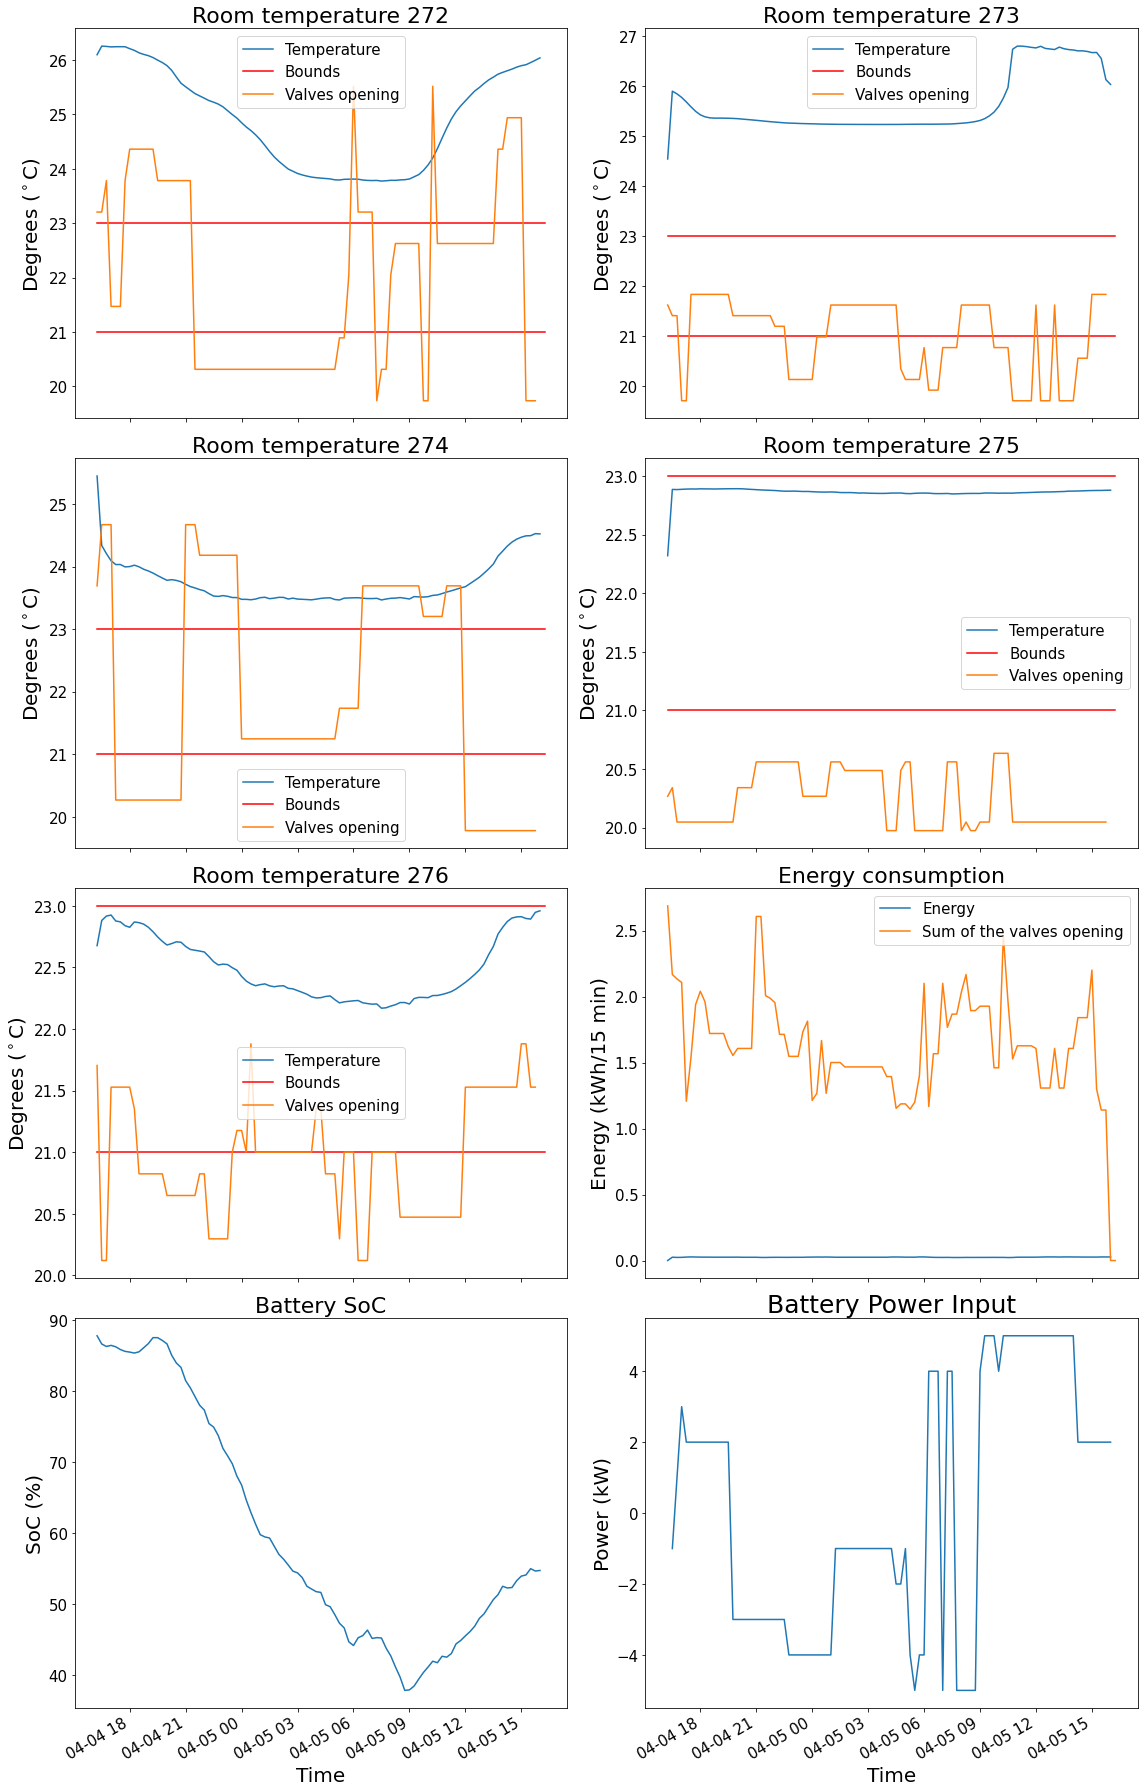

One potentially bad prediction spotted
Eval num_timesteps=2000, episode_reward=-5.56 +/- 0.52
Episode length: 96.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-5.09 +/- 0.71
Episode length: 96.00 +/- 0.00
New best mean reward!
One potentially bad prediction spotted
One potentially bad prediction spotted
Eval num_timesteps=6000, episode_reward=-5.02 +/- 0.68
Episode length: 96.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=-5.34 +/- 0.75
Episode length: 96.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=-5.02 +/- 0.73
Episode length: 96.00 +/- 0.00
Eval num_timesteps=12000, episode_reward=-4.98 +/- 0.64
Episode length: 96.00 +/- 0.00
New best mean reward!
One potentially bad prediction spotted
([array([-5.978245], dtype=float32), array([-5.7106004], dtype=float32), array([-4.596273], dtype=float32), array([-5.8643756], dtype=float32), array([-5.9321012], dtype=float32), array([-6.0800433], dtype=float32), array([-5.76179], dtyp

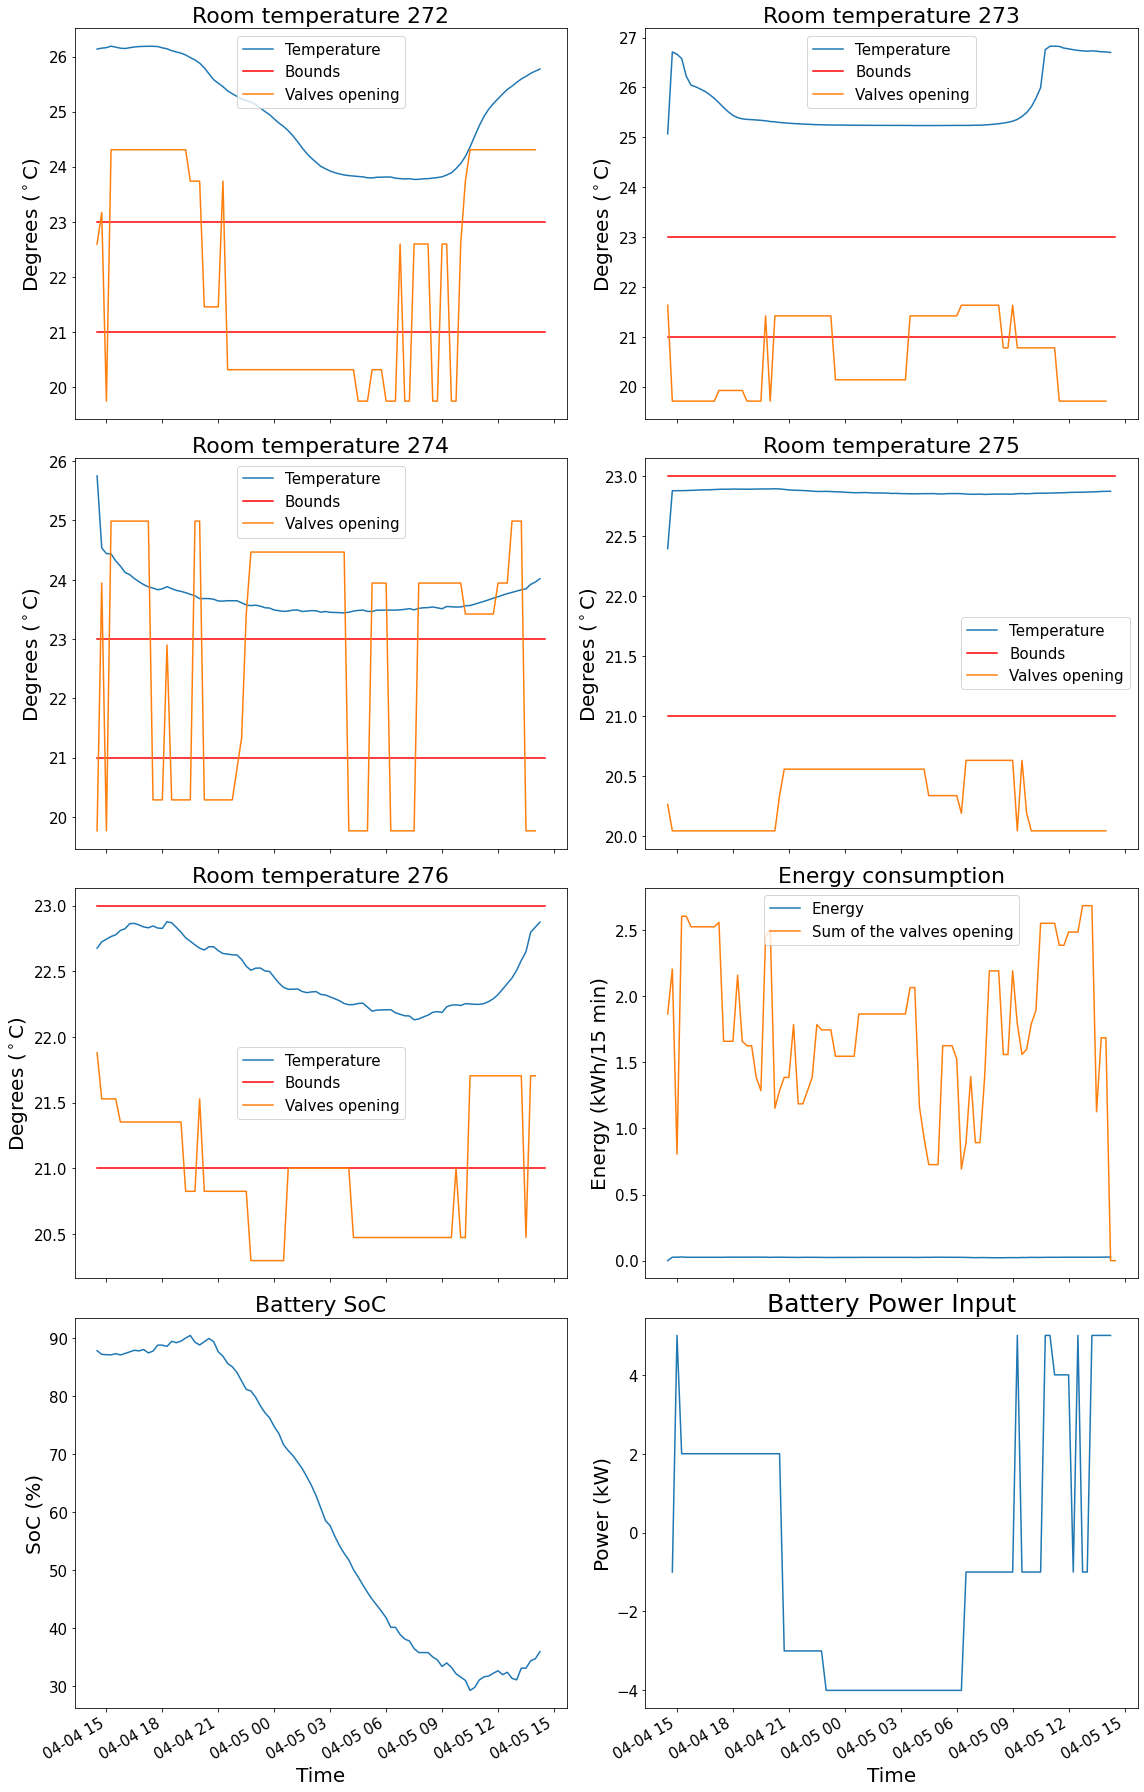

In [56]:
import os

from stable_baselines import A2C
#from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.callbacks import CallbackList, CheckpointCallback#, EvalCallback
from stable_baselines.common.vec_env import VecNormalize, VecCheckNan
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.vec_env import SubprocVecEnv

#if __name__ == "__main__":
env = UMAREnv(umar_model, battery_model, temp_bounds)
env = make_vec_env(lambda: env, n_envs=4, vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
env = VecNormalize(env)

# Separate evaluation env
eval_env = UMAREnv(umar_model, battery_model, temp_bounds)
eval_env = make_vec_env(lambda: eval_env, n_envs=1)
eval_env = VecCheckNan(eval_env, raise_exception=True)
eval_env = VecNormalize(eval_env)

# Use deterministic actions for evaluation
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./logs/')
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

# Create the callback list
callback = CallbackList([checkpoint_callback, eval_callback])

model = A2C(CustomLSTMPolicy, env, tensorboard_log="../saves/Agents/tensorboard/A2C")
print(evaluate_lstm_policy(model, eval_env, return_episode_rewards=True))
evaluate_lstm_policy(model, eval_env, n_eval_episodes=1, render=True)

model.learn(12000, callback=callback, tb_log_name="first_run")

print(evaluate_lstm_policy(model, eval_env, return_episode_rewards=True))
evaluate_lstm_policy(model, eval_env, n_eval_episodes=1, render=True)

# Create save dir
save_dir = "../saves/Agents/"
os.makedirs(save_dir, exist_ok=True)

model.save(save_dir + "/A2C")

#loaded_model = PPO2.load(save_dir + "/PPO2_tutorial")
# Check that the prediction is the same after loading (for the same observation)
#print("loaded", loaded_model.predict(obs, deterministic=True))

In [57]:
eval_env.venv.venv.envs[0]

<Monitor<UMAREnv instance>>

In [58]:
np.array([[0.5,0.5,0.5,0.5,0.5,0.8]])#.reshape(-1,)

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.8]])

In [21]:
obs = eval_env.reset()
for i in range(97):
    action, state = model.predict(obs)
    obs, reward, done, info = eval_env.step(action)
    eval_env.render()
    print(eval_env.current_step)

ValueError: Cannot feed value of shape (1, 31) for Tensor 'input/Ob:0', which has shape '(4, 31)'

In [ ]:
env.reset()
model.learn(total_timesteps=10000, callback=callback)
print(evaluate_policy(model, env, return_episode_rewards=True))
evaluate_policy(model, env, n_eval_episodes=1, render=True)

In [ ]:
obs = env.reset()
model.learn(total_timesteps=10000)
print(evaluate_policy(model, env, return_episode_rewards=True))
evaluate_policy(model, env, n_eval_episodes=3, render=True)

In [ ]:
obs = env.reset()
model.learn(total_timesteps=10000)
print(evaluate_policy(model, env, return_episode_rewards=True))
evaluate_policy(model, env, n_eval_episodes=3, render=True)

In [ ]:
obs = env.reset()
model.learn(total_timesteps=10000)
print(evaluate_policy(model, env, return_episode_rewards=True))
evaluate_policy(model, env, n_eval_episodes=3, render=True)

In [ ]:
obs = env.reset()
model.learn(total_timesteps=10000)
print(evaluate_policy(model, env, return_episode_rewards=True))
evaluate_policy(model, env, n_eval_episodes=3, render=True)

In [ ]:
VecNormalize, VecCheckNan
env = VecCheckNan(env, raise_exception=True)

In [ ]:
# Instantiate the env
env = CustomEnv(arg1, ...)
# Define and Train the agent
model = A2C('CnnPolicy', env).learn(total_timesteps=1000)


In [ ]:
class CustomLSTMPolicy(LstmPolicy):
    def __init__(self, sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm=64, reuse=False, **_kwargs):
        super().__init__(sess, ob_space, ac_space, n_env, n_steps, n_batch, n_lstm, reuse,
                         net_arch=[8, 'lstm', dict(vf=[5, 10], pi=[10])],
                         layer_norm=True, feature_extraction="mlp", **_kwargs)

In [ ]:
import gym

from stable_baselines import SAC
from stable_baselines.common.callbacks import CallbackList, CheckpointCallback, EvalCallback

checkpoint_callback = CheckpointCallback(save_freq=1000, save_path='./logs/')
# Separate evaluation env
eval_env = gym.make('Pendulum-v0')
# Use deterministic actions for evaluation
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/',
                             log_path='./logs/', eval_freq=500,
                             deterministic=True, render=False)

# Create the callback list
callback = CallbackList([checkpoint_callback, eval_callback])

model = SAC('MlpPolicy', 'Pendulum-v0')
# Equivalent to:
# model.learn(5000, callback=[checkpoint_callback, eval_callback])
model.learn(5000, callback=callback)

In [ ]:
# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=-200, verbose=1)
eval_callback = EvalCallback(eval_env, callback_on_new_best=callback_on_best, verbose=1)
model = SAC('MlpPolicy', 'Pendulum-v0', verbose=1)
# Almost infinite number of timesteps, but the training will stop
# early as soon as the reward threshold is reached
model.learn(int(1e10), callback=eval_callback)


In [ ]:
import gym

from stable_baselines import A2C

model = A2C('MlpPolicy', 'CartPole-v1', verbose=1, tensorboard_log="./a2c_cartpole_tensorboard/")
model.learn(total_timesteps=10000, tb_log_name="first_run")
# Pass reset_num_timesteps=False to continue the training curve in tensorboard
# By default, it will create a new curve
model.learn(total_timesteps=10000, tb_log_name="second_run", reset_num_timesteps=False)
model.learn(total_timesteps=10000, tb_log_name="thrid_run", reset_num_timesteps=False)

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
a = pd.DataFrame([1,2],[2,3])

In [ ]:
a


In [ ]:
b = a.values

In [ ]:
b

In [ ]:
b[0] = 4

In [ ]:
b

In [ ]:
a

In [ ]:
x = np.array([1,2,3,4,-5,-6,9])

In [ ]:
x[x<0]